In [64]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [65]:
# style to use for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [66]:
df = pd.read_csv('../data/raw_listings.csv')
print(f"Raw data shape: {df.shape}")
df.head(5)

df.info()
df.describe(include='all')

Raw data shape: (800, 11)
<class 'pandas.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Title          800 non-null    str  
 1   Property Type  800 non-null    str  
 2   Price          800 non-null    str  
 3   Location       800 non-null    str  
 4   Bedrooms       800 non-null    str  
 5   Bathrooms      764 non-null    str  
 6   Size           536 non-null    str  
 7   Amenities      774 non-null    str  
 8   Surroundings   719 non-null    str  
 9   Created At     800 non-null    str  
 10  URL            800 non-null    str  
dtypes: str(11)
memory usage: 375.6 KB


,Title,Property Type,Price,Location,Bedrooms,Bathrooms,Size,Amenities,Surroundings,Created At,URL
count,800,800,800,800,800,764,536,774,719,800,800
unique,434,3,191,77,10,10,184,633,125,85,800
top,5 Bed Townhouse with En Suite in Lavington,House,"KSh 85,000,000",Lavington,5 Bedrooms,5 Bathrooms,450 sqm,"Alarm, Backup Generator, En Suite, Fibre Inter...","Bus Stop, Golf Course, Hospital, Scenic View, ...",17 February 2026,https://www.buyrentkenya.com/listings/3-bedroo...
freq,81,334,37,211,327,229,24,40,182,94,1


In [67]:
# Check for duplicates
print(f"Duplicate URLs: {df['URL'].duplicated().sum()}")
print(f"Duplicate (Title + Price): {df.duplicated(subset=['Title', 'Price']).sum()}")

Duplicate URLs: 0
Duplicate (Title + Price): 136


In [68]:
# ==============================================
#  Remove Duplicates
# drop based on URL (most reliable), then check title+price.


df = df.drop_duplicates(subset=['URL'], keep='first')
print(f"Shape after removing URL duplicates: {df.shape}")

#  also remove title+price duplicates coz wasn't enough... TO AVOID MODEL BIAS LATER ON
df = df.drop_duplicates(subset=['Title', 'Price'], keep='first')
print(f"Shape after removing Title+Price duplicates: {df.shape}")



Shape after removing URL duplicates: (800, 11)
Shape after removing Title+Price duplicates: (664, 11)


In [69]:
# ==========================================
#  CHECK AND HANDLE MISSING VALUES
missing = df.isnull().sum()
missing[missing > 0]


# drop rows with missing critical info (like Price or Location). For other columns, we can decide on a case-by-case basis.
df = df.dropna(subset=['Price', 'Location'])
print(f"Shape after dropping rows with missing Price or Location: {df.shape}")

# for bedrooms/bathrooms/size, fill "N/A" with None for now, then convert
df['Bedrooms'] = df['Bedrooms'].replace('N/A', np.nan)
df['Bathrooms'] = df['Bathrooms'].replace('N/A', np.nan)
df['Size'] = df['Size'].replace('N/A', np.nan)

Shape after dropping rows with missing Price or Location: (664, 11)


In [70]:
# =====================================================
#  STANDARDIZE LOCATION NAMES
# standardize location names by extracting main area name and removing common suffixes like "Area", "Estate", etc.

def clean_location(loc):
    if pd.isna(loc):
        return np.nan
    # Remove common suffixes and extra spaces
    loc = str(loc)
    # Extract the main area name (usually the first part before comma)
    main_area = loc.split(',')[0].strip()
    # Remove words like "Area", "Estate", "Town" if they appear (optional)
    main_area = re.sub(r'\s+(Area|Estate|Town)$', '', main_area, flags=re.IGNORECASE)
    return main_area

df['Location_Clean'] = df['Location'].apply(clean_location)
# Check the mapping
df[['Location', 'Location_Clean']].drop_duplicates().head(20)


,Location,Location_Clean
0,"Gikambura, Kikuyu",Gikambura
1,Kiambu Road,Kiambu Road
2,Lavington,Lavington
4,Malindi,Malindi
5,"Runda, Westlands",Runda
7,"Nyari, Westlands",Nyari
8,Karen Hardy,Karen Hardy
9,Karen,Karen
10,Kitengela,Kitengela
13,"Rosslyn, Westlands",Rosslyn


In [71]:
# =====================================================
#  CONVERT PRICE TO NUMERIC
# Remove currency symbols and commas, then convert to float

def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    # Remove "KSh", commas, and any non-numeric characters except decimal point
    price_clean = re.sub(r'[^\d.]', '', price_str)
    try:
        return float(price_clean)
    except:
        return np.nan

df['Price_Numeric'] = df['Price'].apply(clean_price)

# convert to millions if price is in millions (e.g., "1.5M" -> 1500000)
def to_millions(price):
    if pd.isna(price):
        return np.nan
    return price / 1_000_000

df['Price_Millions'] = df['Price_Numeric'].apply(to_millions)

print(df[['Price', 'Price_Numeric', 'Price_Millions']].head(10))

# Drop rows where price couldn't be parsed
df = df.dropna(subset=['Price_Numeric'])
print(f"Shape after dropping invalid prices: {df.shape}")

# Check price distribution
print("Minimum price (Millions KSh):", df['Price_Millions'].min())
print("Maximum price (Millions KSh):", df['Price_Millions'].max())



             Price  Price_Numeric  Price_Millions
0   KSh 22,500,000     22500000.0            22.5
1   KSh 78,000,000     78000000.0            78.0
2  KSh 160,000,000    160000000.0           160.0
3  KSh 130,000,000    130000000.0           130.0
4   KSh 21,000,000     21000000.0            21.0
5  KSh 135,000,000    135000000.0           135.0
6  KSh 130,000,000    130000000.0           130.0
7  KSh 130,000,000    130000000.0           130.0
8  KSh 120,000,000    120000000.0           120.0
9   KSh 80,000,000     80000000.0            80.0
Shape after dropping invalid prices: (662, 14)
Minimum price (Millions KSh): 0.1084
Maximum price (Millions KSh): 450.0


In [72]:
print(f"Raw data shape: {df.shape}")

df.describe(include='all')

Raw data shape: (662, 14)


,Title,Property Type,Price,Location,Bedrooms,Bathrooms,Size,Amenities,Surroundings,Created At,URL,Location_Clean,Price_Numeric,Price_Millions
count,662,662,662,662,662,628,461,638,586,662,662,662,6.620000e+02,662.000000
unique,432,3,190,76,10,10,176,532,112,81,662,76,NaN,NaN
top,5 Bed Townhouse with En Suite in Lavington,House,"KSh 85,000,000",Lavington,4 Bedrooms,5 Bathrooms,450 sqm,"Alarm, Backup Generator, En Suite, Fibre Inter...","Bus Stop, Golf Course, Hospital, Scenic View, ...",17 February 2026,https://www.buyrentkenya.com/listings/3-bedroo...,Lavington,NaN,NaN
freq,27,296,24,127,268,196,21,32,141,80,1,127,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.165397e+07,81.653965
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.485405e+07,74.854047
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.084000e+05,0.108400
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.342500e+07,23.425000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500000e+07,65.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.145000e+08,114.500000


In [ ]:
#  CONVERT SIZE TO NUMERIC

def extract_size_from_text(text):
    # from messy real estate descriptions, extract realistic built-up/property size... (extraction.ipynb)
    if not text:
        return "N/A"

    text = text.replace(",", "")
    candidates = []

    # ---------------------------------------------------
    # Ranges in sqm (e.g. 350 – 400 sqm, 465 to 476 sqm)
    range_matches = re.findall(
        r'(\d+(\.\d+)?)\s*(?:–|-|to)\s*(\d+(\.\d+)?)\s*(sqm|m²|square meters?)',
        text,
        re.IGNORECASE
    )

    for match in range_matches:
        low = float(match[0])
        high = float(match[2])
        if high >= 30:  # realistic lower bound for Properties
            candidates.append((high, f"{match[0]}–{match[2]} sqm"))

    # ---------------------------------------------------
    # 2. Single sqm values

    sqm_matches = re.findall(
        r'(\d+(\.\d+)?)\s*(sqm|m²|square meters?)',
        text,
        re.IGNORECASE
    )

    for match in sqm_matches:
        value = float(match[0])
        if value >= 30:  # ~ small studio size
            candidates.append((value, f"{match[0]} sqm"))

    # ---------------------------------------------------
    # 3. Square feet (convert to sqm for comparison)
    
    sqft_matches = re.findall(
        r'(\d+(\.\d+)?)\s*(sq\.?\s*ft\.?|sqft)',
        text,
        re.IGNORECASE
    )

    for match in sqft_matches:
        sqft_value = float(match[0])
        if sqft_value >= 300:  # adjusted for Kenya
            sqm_equivalent = sqft_value * 0.092903
            candidates.append((sqm_equivalent, f"{match[0]} sq ft"))

    # ---------------------------------------------------
    # 4. Acres (convert to sqm for comparison)

    acre_matches = re.findall(
        r'(\d+/\d+|\d+(\.\d+)?)\s*-?\s*(acre)',
        text,
        re.IGNORECASE
    )

    for match in acre_matches:
        raw_value = match[0]

        if "/" in raw_value:
            num, denom = raw_value.split("/")
            acre_value = float(num) / float(denom)
        else:
            acre_value = float(raw_value)

        if acre_value >= 0.05:  # ignore unrealistic tiny plots
            sqm_equivalent = acre_value * 4046.86
            candidates.append((sqm_equivalent, f"{raw_value} acre"))

    # ---------------------------------------------------
    # 5. Return largest realistic size, and avoid small sizes that are likely not the property size
    if candidates:
        # Filter out candidates that are too small (e.g., less than 30 sqm)
        filtered_candidates = [c for c in candidates if c[0] >= 30]
        if filtered_candidates:
            return max(filtered_candidates, key=lambda x: x[0])[1]

    return "N/A"


def extract_size_sqm(text):
    """Return size in square meters as float, or np.nan."""
    if pd.isna(text):
        return np.nan
    text = str(text).replace(',', '')
    # First, handle acres (special case)
    acre_match = re.search(r'(\d+/\d+|\d+(\.\d+)?)\s*-?\s*(acre)', text, re.IGNORECASE)
    if acre_match:
        raw = acre_match.group(1)
        if '/' in raw:
            num, den = raw.split('/')
            acres = float(num)/float(den)
        else:
            acres = float(raw)
        return acres * 4046.86

    # For sqm and sqft, use the same regex but convert... attempt to extract any number followed by sqm/m²
    sqm_match = re.search(r'(\d+(\.\d+)?)\s*(sqm|m²|square meters?)', text, re.IGNORECASE)
    if sqm_match:
        return float(sqm_match.group(1))

    sqft_match = re.search(r'(\d+(\.\d+)?)\s*(sq\.?\s*ft\.?|sqft)', text, re.IGNORECASE)
    if sqft_match:
        sqft = float(sqft_match.group(1))
        return sqft * 0.092903

    # If we have a range, take the high end (as before)
    range_match = re.search(r'(\d+(\.\d+)?)\s*(?:–|-|to)\s*(\d+(\.\d+)?)\s*(sqm|m²|square meters?)', text, re.IGNORECASE)
    if range_match:
        high = float(range_match.group(3))
        return high

    return np.nan


df['Size_SQM'] = df['Size'].apply(extract_size_sqm)
print(df[['Size', 'Size_SQM']].head(20))

# Drop extreme outliers (e.g., < 10 sqm or > 2000 sqm – to adjust as needed)
df = df[(df['Size_SQM'] >= 10) & (df['Size_SQM'] <= 2000)]
print(f"Shape after filtering size outliers: {df.shape}")


        Size  Size_SQM
0    223 sqm    223.00
1        NaN       NaN
2    450 sqm    450.00
3        NaN       NaN
4    506 sqm    506.00
5    500 sqm    500.00
6    475 sqm    475.00
7   1/2 acre   2023.43
8     1 acre   4046.86
9    399 sqm    399.00
10       NaN       NaN
12  3150 sqm   3150.00
13       NaN       NaN
14   395 sqm    395.00
15       NaN       NaN
17   450 sqm    450.00
18   399 sqm    399.00
19       NaN       NaN
20       NaN       NaN
21       NaN       NaN
Shape after filtering size outliers: (359, 15)


In [74]:
# ==================================================================
#  Create New Features


#  price_per_sqm
df['Price_per_SQM'] = df['Price_Numeric'] / df['Size_SQM']

# amenity_score (count of amenities)
df['Amenity_Count'] = df['Amenities'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# month and year from Created At
def parse_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        # Format like "09 February 2026"
        return datetime.strptime(date_str, '%d %B %Y')
    except:
        return pd.NaT

df['Created_Date'] = df['Created At'].apply(parse_date)
df['Month'] = df['Created_Date'].dt.month
df['Year'] = df['Created_Date'].dt.year

# bedrooms/bathrooms as integers...(incase there is a text like "3 Bedrooms" or "2 Bathrooms", extract the number)
def extract_number(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'\d+', str(text))
    return int(match.group()) if match else np.nan

df['Bedrooms_Num'] = df['Bedrooms'].apply(extract_number)
df['Bathrooms_Num'] = df['Bathrooms'].apply(extract_number)


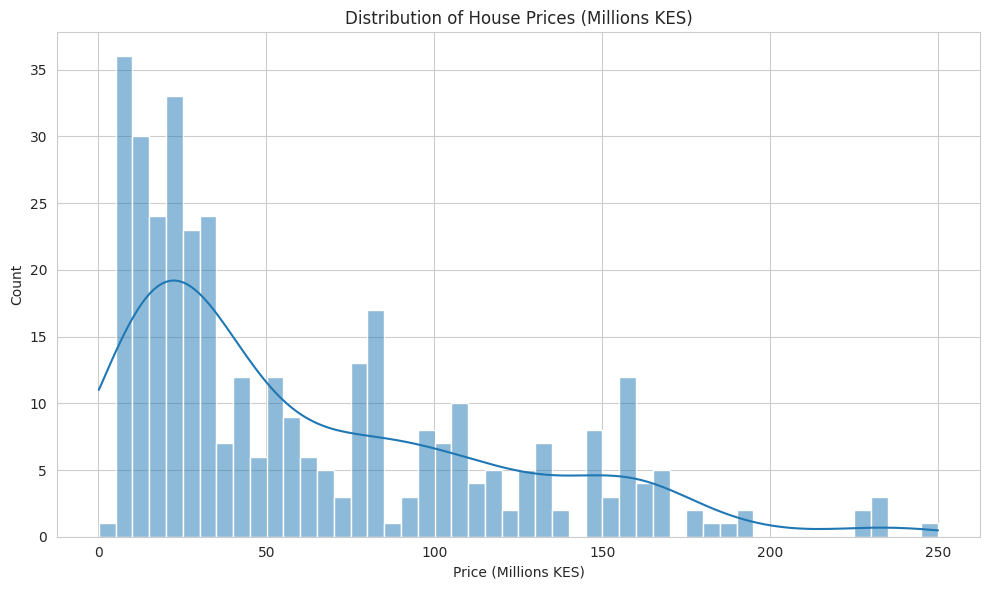

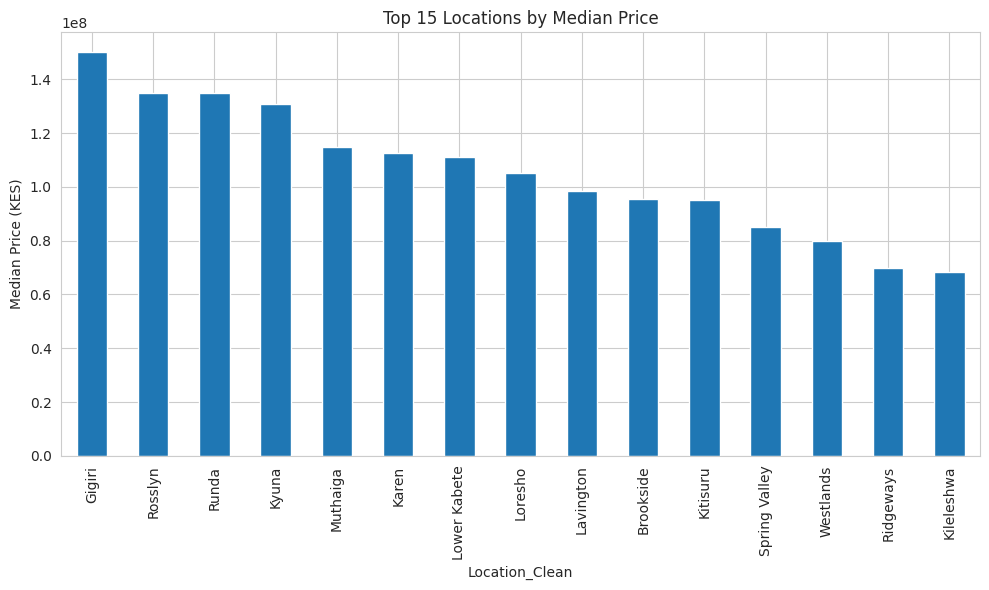

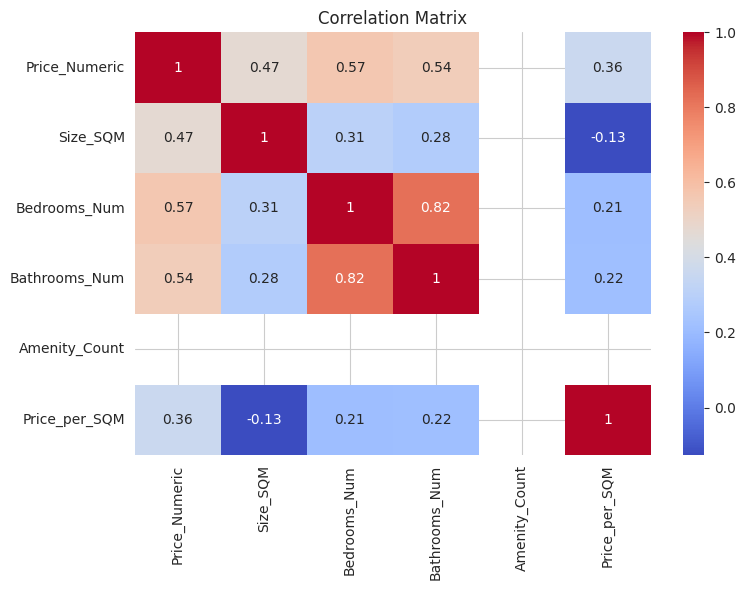

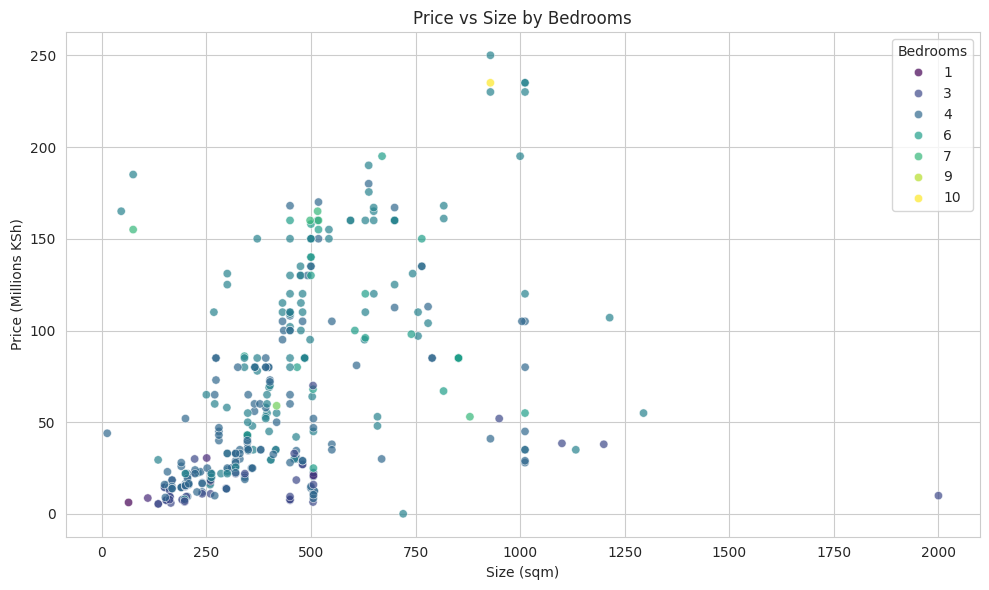

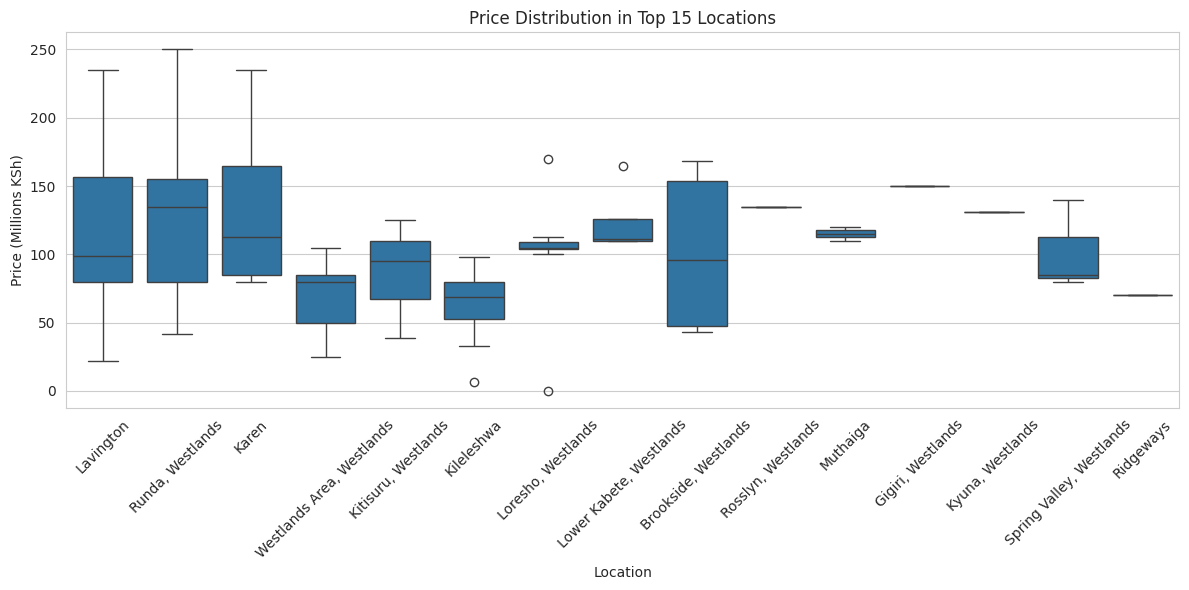

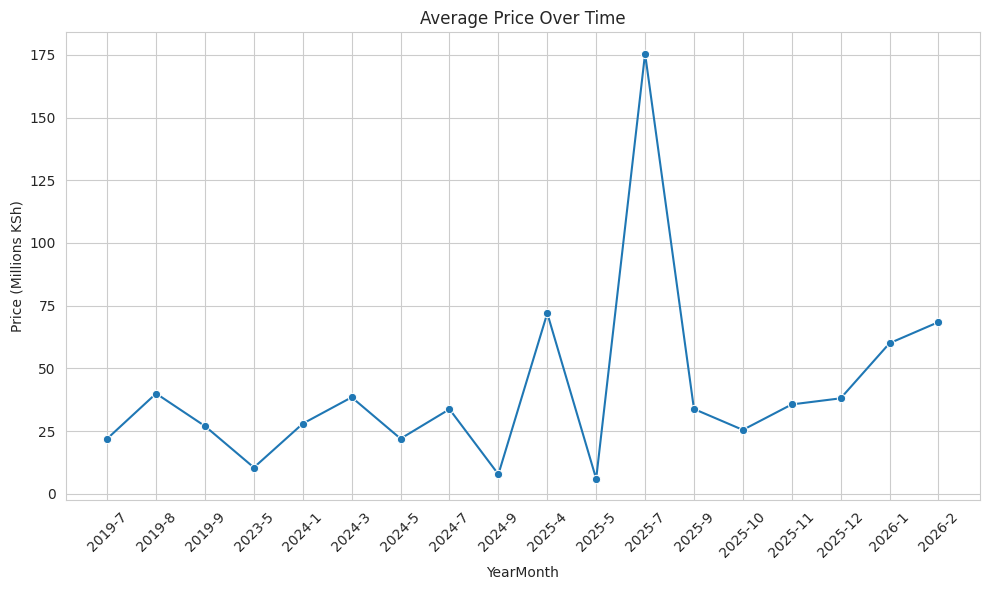

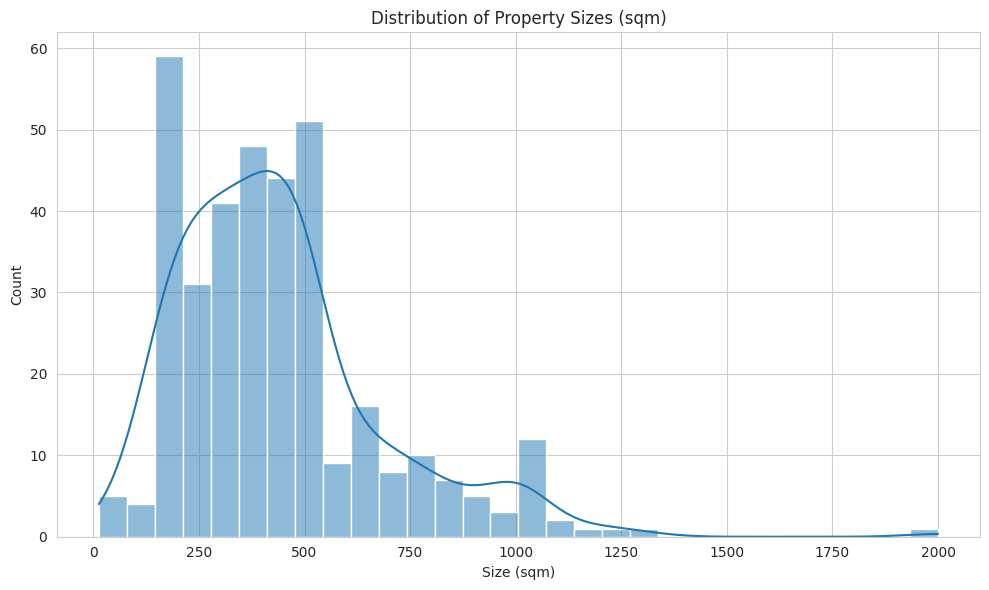

In [75]:
# ===========================================================
# Basic EDA

filename='../reports'
os.makedirs(filename, exist_ok=True)

# Summary statistics for numeric columns
df[['Price_Numeric', 'Size_SQM', 'Price_per_SQM', 'Bedrooms_Num', 'Bathrooms_Num', 'Amenity_Count']].describe()


# Distribution of prices
plt.figure()
sns.histplot(df['Price_Millions'], bins=50, kde=True)
plt.title('Distribution of House Prices (Millions KES)')
plt.xlabel('Price (Millions KES)')
plt.tight_layout()
plt.savefig('../reports/price_distribution.png')
plt.show()


# Top locations by median price
top_locs = df.groupby('Location_Clean')['Price_Numeric'].median().sort_values(ascending=False).head(15)
plt.figure()
top_locs.plot(kind='bar')
plt.title('Top 15 Locations by Median Price')
plt.ylabel('Median Price (KES)')
plt.tight_layout()
plt.savefig('../reports/top_locations.png')
plt.show()


# Correlation heatmap
numeric_cols = ['Price_Numeric', 'Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num', 'Amenity_Count', 'Price_per_SQM']
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('../reports/correlation.png')
plt.show()

# Price vs Size scatter plot colored by number of bedrooms
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Size_SQM',
    y='Price_Millions',
    hue='Bedrooms_Num',
    palette='viridis',
    alpha=0.7
)
plt.title('Price vs Size by Bedrooms')
plt.xlabel('Size (sqm)')
plt.ylabel('Price (Millions KSh)')
plt.legend(title='Bedrooms')
plt.tight_layout()
plt.savefig('../reports/price_vs_size_by_bedrooms.png')
plt.show()


# Boxplot of price distribution by top locations
plt.figure(figsize=(12,6))
top_locations = df.groupby('Location')['Price_Millions'].median().sort_values(ascending=False).head(15).index
sns.boxplot(data=df[df['Location'].isin(top_locations)],
            x='Location', y='Price_Millions')
plt.xticks(rotation=45)
plt.title('Price Distribution in Top 15 Locations')
plt.ylabel('Price (Millions KSh)')
plt.tight_layout()
plt.show()


# Average price over time (by month-year)
monthly = df.groupby(['Year','Month'])['Price_Millions'].mean().reset_index()
monthly['YearMonth'] = monthly['Year'].astype(str) + '-' + monthly['Month'].astype(str)

sns.lineplot(data=monthly, x='YearMonth', y='Price_Millions', marker='o')
plt.xticks(rotation=45)
plt.title('Average Price Over Time')
plt.ylabel('Price (Millions KSh)')
plt.tight_layout()
plt.show()


# Distribution of property sizes
plt.figure(figsize=(10,6))
sns.histplot(df['Size_SQM'], bins=30, kde=True)
plt.title('Distribution of Property Sizes (sqm)')
plt.xlabel('Size (sqm)')
plt.tight_layout()
plt.savefig('../reports/size_distribution.png')
plt.show()



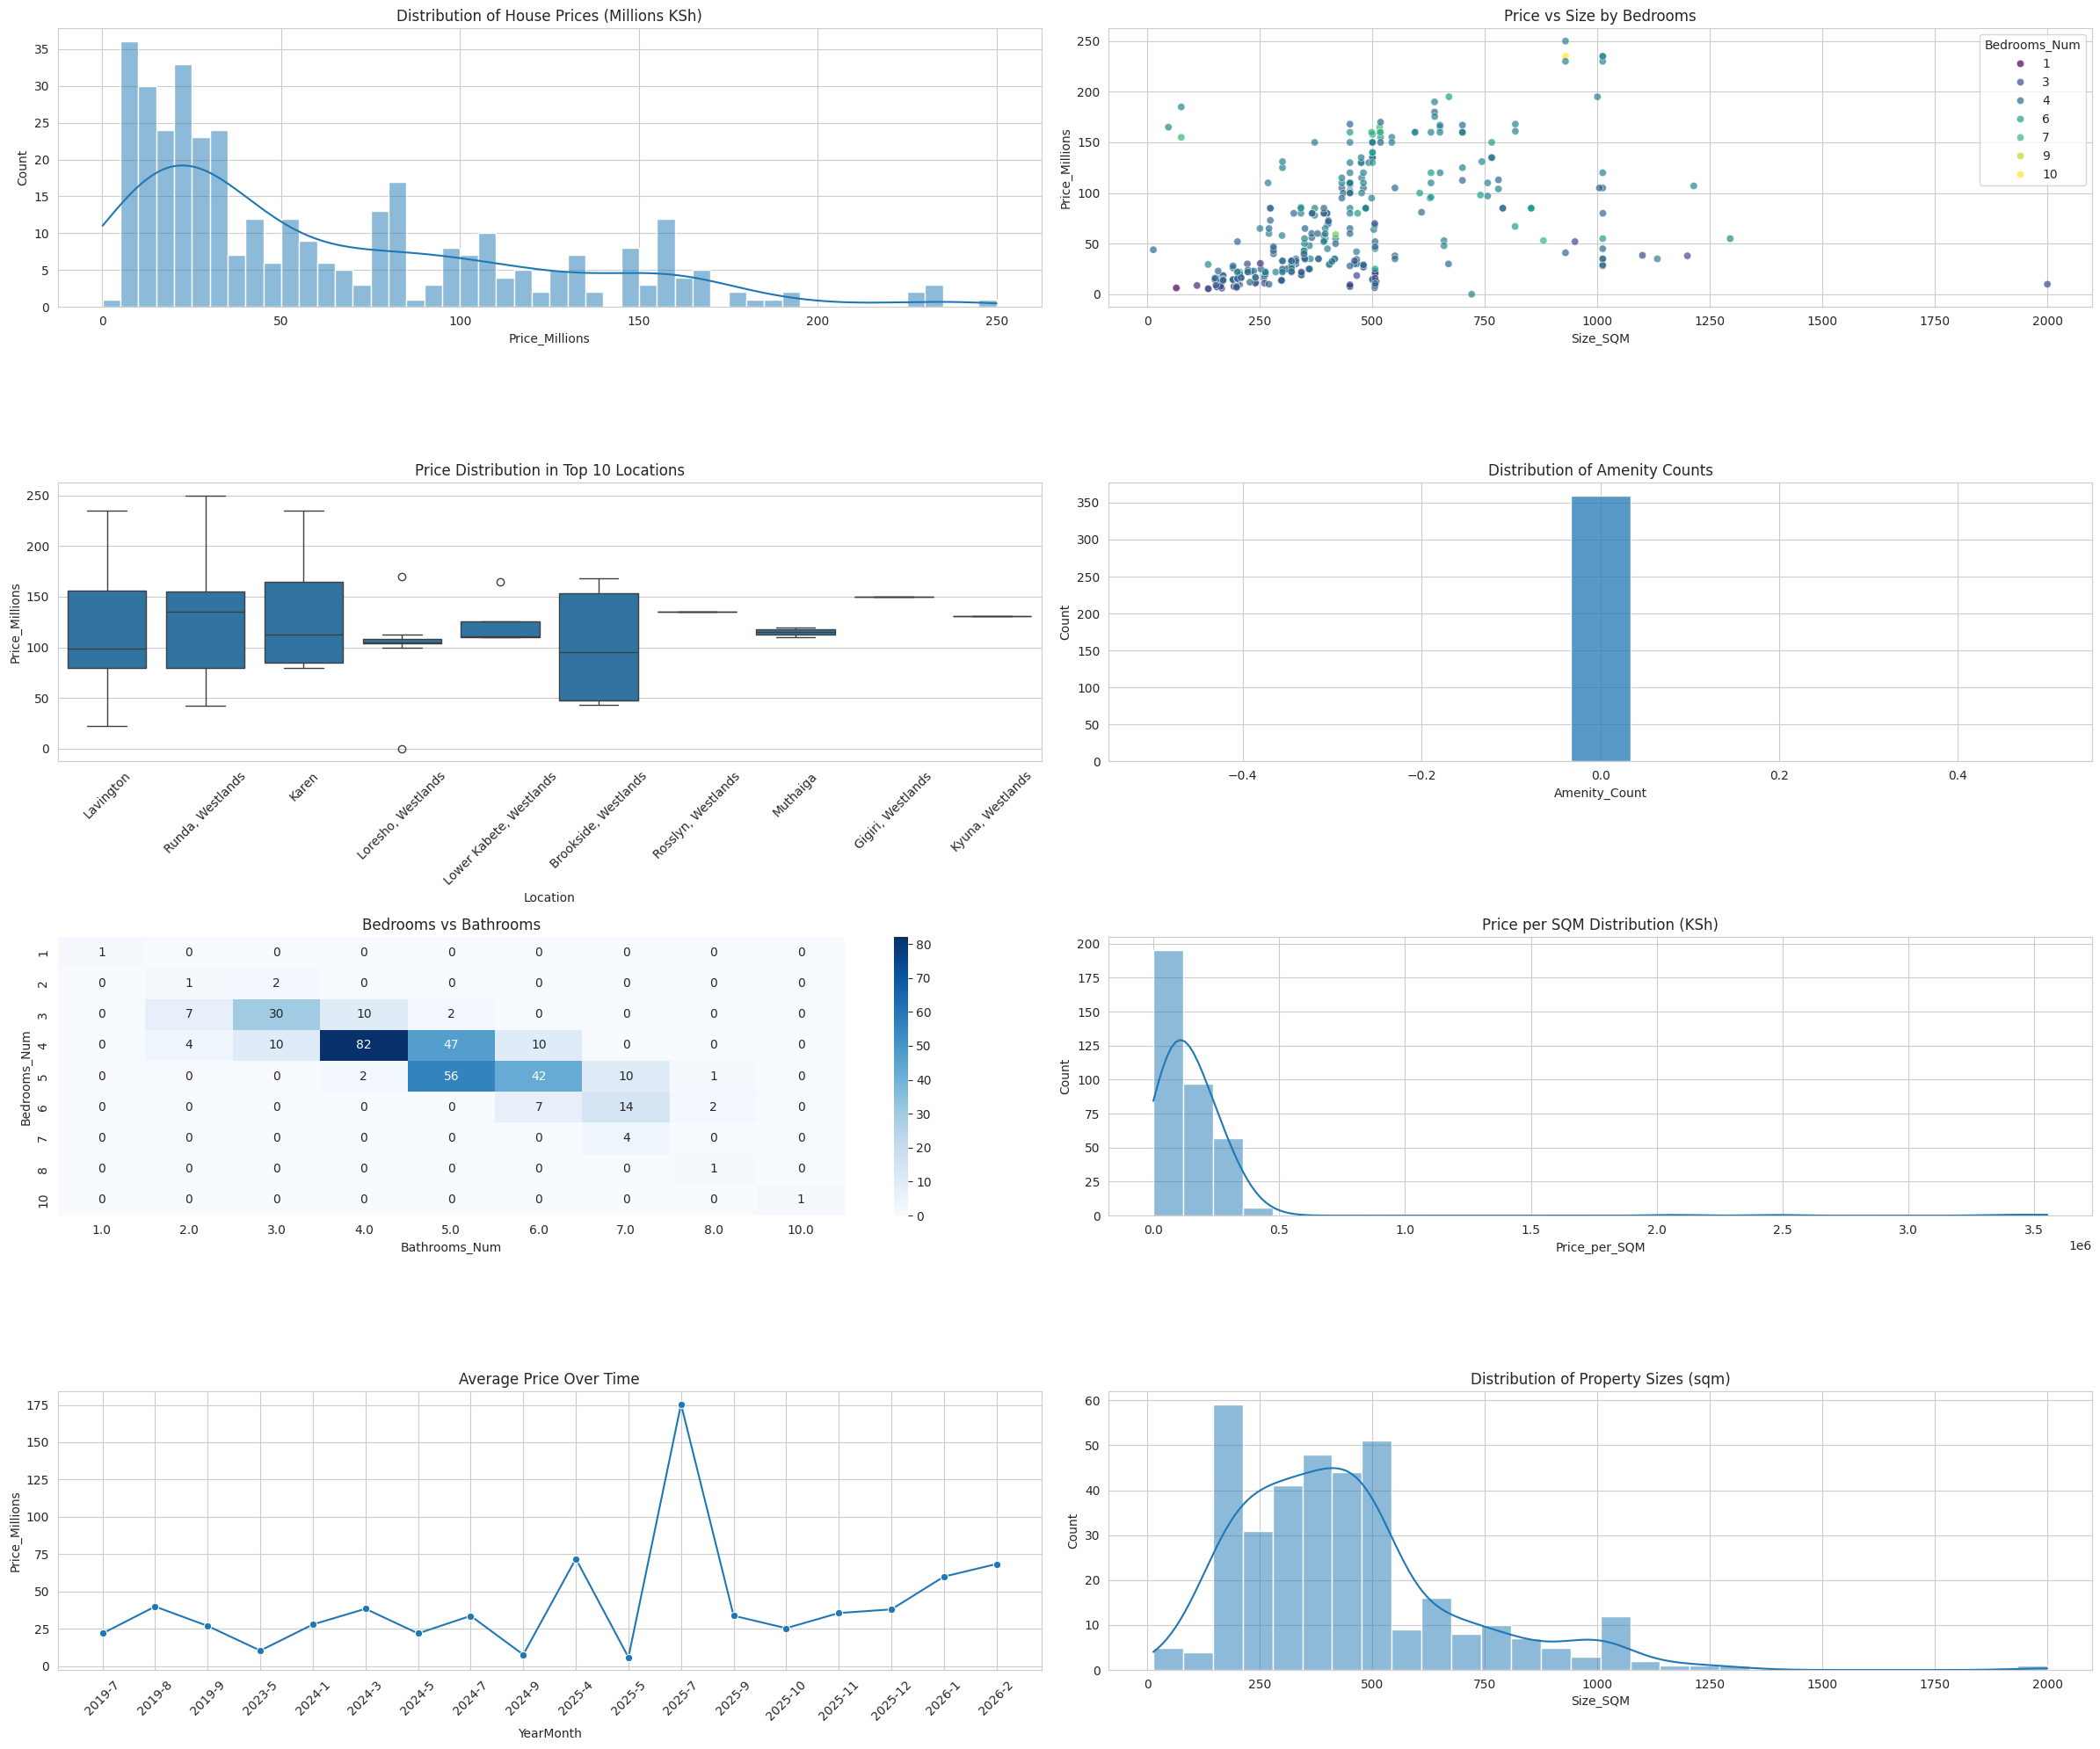

In [79]:
# create a 2x4 grid of plots for various EDA insights
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)

fig, axes = plt.subplots(4, 2, figsize=(24, 20))
axes = axes.flatten()

# 1. Price distribution
sns.histplot(df['Price_Millions'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of House Prices (Millions KSh)')

# 2. Price vs Size
sns.scatterplot(x='Size_SQM', y='Price_Millions', hue='Bedrooms_Num', 
                data=df, alpha=0.7, ax=axes[1], palette='viridis')
axes[1].set_title('Price vs Size by Bedrooms')

# 3. Boxplot: Price by top 10 locations
top_locs = df.groupby('Location')['Price_Millions'].median().sort_values(ascending=False).head(10).index
sns.boxplot(x='Location', y='Price_Millions', data=df[df['Location'].isin(top_locs)], ax=axes[2])
axes[2].set_title('Price Distribution in Top 10 Locations')
axes[2].tick_params(axis='x', rotation=45)

# 4. Amenities count distribution
sns.histplot(df['Amenity_Count'], bins=15, ax=axes[3])
axes[3].set_title('Distribution of Amenity Counts')

# 5. Bedrooms vs Bathrooms heatmap
bed_bath = pd.crosstab(df['Bedrooms_Num'], df['Bathrooms_Num'])
sns.heatmap(bed_bath, annot=True, fmt='d', cmap='Blues', ax=axes[4])
axes[4].set_title('Bedrooms vs Bathrooms')

# 6. Price per sqm distribution
sns.histplot(df['Price_per_SQM'], bins=30, kde=True, ax=axes[5])
axes[5].set_title('Price per SQM Distribution (KSh)')

# 7. Average price by month/year
monthly = df.groupby(['Year','Month'])['Price_Millions'].mean().reset_index()
monthly['YearMonth'] = monthly['Year'].astype(str) + '-' + monthly['Month'].astype(str)
sns.lineplot(x='YearMonth', y='Price_Millions', data=monthly, marker='o', ax=axes[6])
axes[6].set_title('Average Price Over Time')
axes[6].tick_params(axis='x', rotation=45)

# 8. Size distribution
sns.histplot(df['Size_SQM'], bins=30, kde=True, ax=axes[7])
axes[7].set_title('Distribution of Property Sizes (sqm)')

# save the combined figure
plt.savefig('../reports/comprehensive_eda.png')

plt.tight_layout()
plt.show()


In [77]:
# ======================================================
# SAVE CLEANED DATASET


# Select relevant columns for modeling
clean_df = df[['Title', 'Property Type', 'Location_Clean', 'Bedrooms_Num', 'Bathrooms_Num',
               'Size_SQM', 'Amenities', 'Surroundings', 'Price_Numeric', 'Price_Millions', 'Price_per_SQM',
               'Amenity_Count', 'Month', 'Year', 'URL']].copy()
clean_df.rename(columns={'Location_Clean': 'Location'}, inplace=True)

# Save
os.makedirs('../data', exist_ok=True)
clean_df.to_csv('../data/clean_listings.csv', index=False)
print("Clean data saved to ../data/clean_listings.csv")


Clean data saved to ../data/clean_listings.csv
